## Load raw data and prepare train set

In [3]:
import numpy as np
import pandas as pd
import datetime as dt
import os
import codecs

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

import re
import pickle

import nltk

### Utility Functions

In [164]:
def clean_contents(df):
    df['contents'] = df['contents'].map(lambda x: x.replace('\n','. ').replace('\r','. '))
    df['contents'] = df['contents'].map(lambda x: re.sub('(\. )(\. )+', '. ', x))
    df['word_count'] = None
    for i in range(len(df)):
        input_words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', df["contents"][i].lower())
        df['word_count'][i] = len(input_words)

def get_statement_date(x):
    if statements.index[0] > x:
        return None
    else:
        for i in range(len(statements)):
            if x <= statements.index[i]:
                return statements.index[i]
        return None

def get_rate_change(x):
    if statements.index[0] > x:
        return None
    else:
        for i in range(len(statements)):
            if x <= statements.index[i]:
                return int(statements['RateChange'][i])
        return None

def get_rate(x):
    if statements.index[0] > x:
        return None
    else:
        for i in range(len(statements)):
            if x <= statements.index[i]:
                return int(statements['Rate'][i])
        return None

### Load Statement Data

In [165]:
file = open('../data/FOMC/statement.pickle', 'rb')

statements = pickle.load(file)
file.close()

statements.index.name = 'Date'
statements.head(10)

,contents
Date,
1994-02-04,Chairman Alan Greenspan announced today that t...
1994-03-22,Chairman Alan Greenspan announced today that t...
1994-04-18,Chairman Alan Greenspan announced today that t...
1994-05-17,The Federal Reserve today announced two action...
1994-08-16,The Federal Reserve announced today the follow...
1994-11-15,The Federal Reserve Board today approved an in...
1995-02-01,For immediate release\n\nThe Federal Reserve B...
1995-07-06,For immediate release\n\nChairman Alan Greensp...
1995-12-19,For immediate release\n\nChairman Alan Greensp...


In [166]:
clean_contents(statements)
statements.head(10)

,contents,word_count
Date,,
1994-02-04,Chairman Alan Greenspan announced today that t...,99
1994-03-22,Chairman Alan Greenspan announced today that t...,40
1994-04-18,Chairman Alan Greenspan announced today that t...,37
1994-05-17,The Federal Reserve today announced two action...,160
1994-08-16,The Federal Reserve announced today the follow...,137
1994-11-15,The Federal Reserve Board today approved an in...,139
1995-02-01,For immediate release. The Federal Reserve Boa...,144
1995-07-06,For immediate release. Chairman Alan Greenspan...,70
1995-12-19,For immediate release. Chairman Alan Greenspan...,84


### Load FED Rate Data
First tried to retrieve from contents, but it was not always accurate.
Thus, load historical FED Rate and match by the dates

Downloaded from FRB of New York (https://apps.newyorkfed.org/markets/autorates/fed%20funds)

In [122]:
# Load FED Target Rates
filename = '../data/MarketData/FEDRates/ffs-01172000-02092020.csv'

fedrates = pd.read_csv(filename, header=0, names=('Date', 'Vol', 'EFFR', '1st','25th' ,'75th' ,'99th' ,'Target' ,'Low' ,'High','Std.' ))
fedrates.index = pd.to_datetime(fedrates.Date, format="%d/%m/%Y")
fedrates.dropna(inplace=True, axis=0, subset=['Date', 'Target'])
fedrates.drop(columns=['Date', 'Vol', 'EFFR', '1st','25th' ,'75th' ,'99th','Low' ,'High','Std.'], inplace=True)

# Separate Range to Low and High
fedrates['Low'] = None
fedrates['High'] = None

for i in range(fedrates.shape[0]):
    target = fedrates['Target'][i]
    if '-' in target:
        fedrates['Low'][i] = re.findall(r'([0-9.]+)-', target)[0]
        fedrates['High'][i] = re.findall(r'-([0-9.]+)', target)[0]
    else:
        (fedrates['Low'][i], fedrates['High'][i]) = (target, target)

fedrates

,Target,Low,High
Date,,,
2020-02-06,1.50-1.75,1.50,1.75
2020-02-05,1.50-1.75,1.50,1.75
2020-02-04,1.50-1.75,1.50,1.75
2020-02-03,1.50-1.75,1.50,1.75
2020-01-31,1.50-1.75,1.50,1.75
2020-01-30,1.50-1.75,1.50,1.75
2020-01-29,1.50-1.75,1.50,1.75
2020-01-28,1.50-1.75,1.50,1.75
2020-01-27,1.50-1.75,1.50,1.75


In [124]:
fedrates.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4925 entries, 2020-02-06 to 2000-07-03
Data columns (total 3 columns):
Target    4925 non-null object
Low       4925 non-null object
High      4925 non-null object
dtypes: object(3)
memory usage: 313.9+ KB


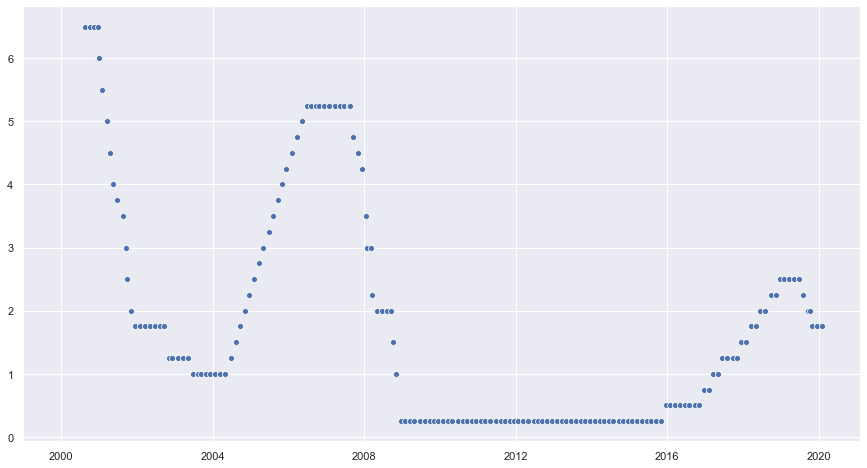

In [125]:
plt.figure(figsize=(15,8))
ax = sns.scatterplot(data=statements["TargetHigh"])

As FRB of New York has historical data only from 2020, check FRB of St. Louis (https://fred.stlouisfed.org/categories/118)

In [167]:
filename_till08 = '../data/MarketData/FEDRates/DFEDTAR.csv'
filename_from08u = '../data/MarketData/FEDRates/DFEDTARL.csv'
filename_from08l = '../data/MarketData/FEDRates/DFEDTARU.csv'

fedtar = pd.read_csv(filename_till08, names=['Date', 'Rate'], header=0)
fedtaru = pd.read_csv(filename_from08u, names=['Date', 'Rate'], header=0)
fedrate_df = pd.concat([fedtar, fedtaru], axis=0)
fedrate_df.index = pd.to_datetime(fedrate_df.Date, format="%Y-%m-%d")
fedrate_df.drop(columns=['Date'], inplace=True)
fedrate_df['Rate'] = fedrate_df['Rate'].map(lambda x: np.float(x))
fedrate_df

,Rate
Date,
1982-09-27,10.25
1982-09-28,10.25
1982-09-29,10.25
1982-09-30,10.25
1982-10-01,10.00
1982-10-02,10.00
1982-10-03,10.00
1982-10-04,10.00
1982-10-05,10.00


In [ ]:
fig, ax = plt.subplots()
ax.plot(fedrate_df.index, fedrate_df['Rate'].values, 
         c = 'green',
         linewidth= 1.0)

ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.grid(True)

plt.show()

### Retrieve Rate Decisions from contents

In [168]:
statements['RateChange'] = None
statements['Rate'] = None

for i in range(len(statements)):
    for j in range(len(fedrate_df)):
        if statements.index[i] == fedrate_df.index[j]:
            statements['Rate'][i] = float(fedrate_df['Rate'][j+1])
            if fedrate_df['Rate'][j-1] == fedrate_df['Rate'][j+1]:
                statements['RateChange'][i] = 0
            elif fedrate_df['Rate'][j-1] < fedrate_df['Rate'][j+1]:
                statements['RateChange'][i] = 1
            elif fedrate_df['Rate'][j-1] > fedrate_df['Rate'][j+1]:
                statements['RateChange'][i] = -1

statements.head(10)

,contents,word_count,RateChange,Rate
Date,,,,
1994-02-04,Chairman Alan Greenspan announced today that t...,99,1,3.25
1994-03-22,Chairman Alan Greenspan announced today that t...,40,1,3.5
1994-04-18,Chairman Alan Greenspan announced today that t...,37,1,3.75
1994-05-17,The Federal Reserve today announced two action...,160,1,4.25
1994-08-16,The Federal Reserve announced today the follow...,137,1,4.75
1994-11-15,The Federal Reserve Board today approved an in...,139,1,5.5
1995-02-01,For immediate release. The Federal Reserve Boa...,144,1,6
1995-07-06,For immediate release. Chairman Alan Greenspan...,70,-1,5.75
1995-12-19,For immediate release. Chairman Alan Greenspan...,84,-1,5.5


In [169]:
statements.tail(10)

,contents,word_count,RateChange,Rate
Date,,,,
2019-01-30,"The Federal Reserve, the central bank of the U...",482,0,2.25
2019-03-20,"The Federal Reserve, the central bank of the U...",498,0,2.25
2019-05-01,"The Federal Reserve, the central bank of the U...",474,0,2.25
2019-06-19,"The Federal Reserve, the central bank of the U...",538,0,2.25
2019-07-31,"The Federal Reserve, the central bank of the U...",555,-1,2
2019-09-18,"The Federal Reserve, the central bank of the U...",509,-1,1.75
2019-10-11,"The Federal Reserve, the central bank of the U...",466,0,1.75
2019-10-30,"The Federal Reserve, the central bank of the U...",746,-1,1.5
2019-12-11,"The Federal Reserve, the central bank of the U...",501,0,1.5


In [171]:
# Reorganize the dataframe
statement_df = pd.DataFrame(statements["contents"])
statement_df["target"] = statements["RateChange"]
statement_df["rate"] = statements["Rate"]
statement_df["stmt_date"] = statements.index
statement_df["type"] = "statement"
statement_df.dropna(subset=['target'], axis=0, inplace=True)

# Add QE as target = -1
statement_df = statement_df.append(
    pd.Series(["The Federal Reserve announced on Tuesday that it will initiate a program to purchase the direct obligations of housing-related government-sponsored enterprises (GSEs)--Fannie Mae, Freddie Mac, and the Federal Home Loan Banks--and mortgage-backed securities (MBS) backed by Fannie Mae, Freddie Mac, and Ginnie Mae.  Spreads of rates on GSE debt and on GSE-guaranteed mortgages have widened appreciably of late.  This action is being taken to reduce the cost and increase the availability of credit for the purchase of houses, which in turn should support housing markets and foster improved conditions in financial markets more generally. Purchases of up to $100 billion in GSE direct obligations under the program will be conducted with the Federal Reserve's primary dealers through a series of competitive auctions and will begin next week.  Purchases of up to $500 billion in MBS will be conducted by asset managers selected via a competitive process with a goal of beginning these purchases before year-end.  Purchases of both direct obligations and MBS are expected to take place over several quarters.  Further information regarding the operational details of this program will be provided after consultation with market participants.", -1,0, dt.datetime.strptime('2008-11-25', '%Y-%m-%d'),'statement'], index=statement_df.columns, name=dt.datetime.strptime('2008-11-25', '%Y-%m-%d')),
)

statement_df.loc['2009-03-18', 'target'] = -1
statement_df.loc['2010-11-03', 'target'] = -1
statement_df.loc['2011-09-21', 'target'] = -1
statement_df.loc['2012-06-20', 'target'] = -1
statement_df.loc['2012-09-13', 'target'] = -1
statement_df.loc['2013-12-18', 'target'] = 1

clean_contents(statement_df)
statement_df

/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [173]:
file = open('../data/FOMC/minutes.pickle', 'rb')

minutes_df = pickle.load(file)
file.close()

minutes_df.index.name = 'Date'
minutes_df

,contents
Date,
1993-02-03,A meeting of the Federal Open Market Committee...
1993-03-23,A meeting of the Federal Open Market Committee...
1993-05-18,A meeting of the Federal Open Market Committee...
1993-07-07,A meeting of the Federal Open Market Committee...
1993-08-17,A meeting of the Federal Open Market Committee...
1993-09-21,A meeting of the Federal Open Market Committee...
1993-11-16,A meeting of the Federal Open Market Committee...
1993-12-21,A meeting of the Federal Open Market Committee...
1994-02-04,A meeting of the Federal Open Market Committee...


In [174]:
clean_contents(minutes_df)
minutes_df['rate'] = minutes_df.index.map(get_rate)
minutes_df['target'] = minutes_df.index.map(get_rate_change)
minutes_df['stmt_date'] = minutes_df.index.map(get_statement_date)
minutes_df["type"] = "minutes"
minutes_df.dropna(inplace=True, axis=0, subset=['target'])
minutes_df

,contents,word_count,rate,target,stmt_date,type
Date,,,,,,
1994-02-04,A meeting of the Federal Open Market Committee...,10190,3.0,1.0,1994-02-04,minutes
1994-03-22,A meeting of the Federal Open Market Committee...,6381,3.0,1.0,1994-03-22,minutes
1994-03-22,A meeting of the Federal Open Market Committee...,6381,3.0,1.0,1994-03-22,minutes
1994-05-17,A meeting of the Federal Open Market Committee...,4927,4.0,1.0,1994-05-17,minutes
1994-07-06,A meeting of the Federal Open Market Committee...,6654,4.0,1.0,1994-08-16,minutes
1994-08-16,A meeting of the Federal Open Market Committee...,4928,4.0,1.0,1994-08-16,minutes
1994-09-27,A meeting of the Federal Open Market Committee...,5117,5.0,1.0,1994-11-15,minutes
1994-11-15,A meeting of the Federal Open Market Committee...,5532,5.0,1.0,1994-11-15,minutes
1994-12-20,A meeting of the Federal Open Market Committee...,5723,6.0,1.0,1995-02-01,minutes


In [175]:
file = open('../data/FOMC/speech.pickle', 'rb')

speech_df = pickle.load(file)
file.close()

speech_df.index.name = 'Date'
speech_df

,contents
Date,
1996-06-13,Remarks by Chairman Alan Greenspan\nBank super...
1996-06-18,"Remarks by Governor Edward W. Kelley, Jr.\nDev..."
1996-09-08,Monetary Policy Objectives and Strategy\n\r\nI...
1996-09-19,Remarks by Chairman Alan Greenspan\nRegulation...
1996-10-02,Remarks by Governor Lawrence B. Lindsey\r\nAt ...
1996-10-05,Remarks by Chairman Alan Greenspan\nBank super...
1996-10-07,Remarks by Chairman Alan Greenspan\nU.S. Treas...
1996-10-09,Remarks by Governor Lawrence B. Lindsey\r\nAt ...
1996-10-11,Remarks by Governor Lawrence B. Lindsey\r\nAt ...


In [176]:
clean_contents(speech_df)
speech_df['rate'] = speech_df.index.map(get_rate)
speech_df['target'] = speech_df.index.map(get_rate_change)
speech_df['stmt_date'] = speech_df.index.map(get_statement_date)
speech_df["type"] = "speech"
speech_df.dropna(inplace=True, axis=0, subset=['target'])

speech_df

,contents,word_count,rate,target,stmt_date,type
Date,,,,,,
1996-06-13,Remarks by Chairman Alan Greenspan. Bank super...,57672,5.0,1.0,1997-03-25,speech
1996-06-18,"Remarks by Governor Edward W. Kelley, Jr.. Dev...",28711,5.0,1.0,1997-03-25,speech
1996-09-08,Monetary Policy Objectives and Strategy. I wan...,43969,5.0,1.0,1997-03-25,speech
1996-09-19,Remarks by Chairman Alan Greenspan. Regulation...,13139,5.0,1.0,1997-03-25,speech
1996-10-02,Remarks by Governor Lawrence B. Lindsey. At th...,12465,5.0,1.0,1997-03-25,speech
1996-10-05,Remarks by Chairman Alan Greenspan. Bank super...,15864,5.0,1.0,1997-03-25,speech
1996-10-07,Remarks by Chairman Alan Greenspan. U.S. Treas...,6412,5.0,1.0,1997-03-25,speech
1996-10-09,Remarks by Governor Lawrence B. Lindsey. At th...,14356,5.0,1.0,1997-03-25,speech
1996-10-11,Remarks by Governor Lawrence B. Lindsey. At th...,25567,5.0,1.0,1997-03-25,speech


In [177]:
file = open('../data/FOMC/script.pickle', 'rb')

script_df = pickle.load(file)
file.close()

script_df.index.name = 'Date'
script_df

,contents
Date,
1990-02-07,"December 16, 2015 Chair Yellen’s Press Confere..."
1990-03-27,FOMC Meeting Transcript\n\n\nMeeting of the Fe...
1990-05-15,FOMC Meeting Transcript\n\n\nMeeting of the Fe...
1990-07-03,FOMC Meeting Transcript\n\n\nMeeting of the Fe...
1990-08-21,FOMC Meeting Transcript\n\n\nMeeting of the Fe...
1990-10-02,FOMC Meeting Transcript\n\n\nMeeting of the Fe...
1990-11-13,FOMC Meeting Transcript\n\n\nMeeting of the Fe...
1990-12-18,FOMC Meeting Transcript\n\n\nMeeting of the Fe...
1991-02-06,FOMC Meeting Transcript\n\n\nMeeting of the Fe...


In [178]:
clean_contents(script_df)
script_df['rate'] = script_df.index.map(get_rate)
script_df['target'] = script_df.index.map(get_rate_change)
script_df['stmt_date'] = script_df.index.map(get_statement_date)
script_df["type"] = "script"
script_df.dropna(inplace=True, axis=0, subset=['target'])

script_df

,contents,word_count,rate,target,stmt_date,type
Date,,,,,,
1994-02-04,FOMC Meeting Transcript. Prefatory Note. This ...,34182,3.0,1.0,1994-02-04,script
1994-03-22,FOMC Meeting Transcript. Meeting of the Federa...,33282,3.0,1.0,1994-03-22,script
1994-05-17,FOMC Meeting Transcript. Meeting of the Federa...,21115,4.0,1.0,1994-05-17,script
1994-07-06,FOMC Meeting Transcript. Meeting of the Federa...,43104,4.0,1.0,1994-08-16,script
1994-08-16,FOMC Meeting Transcript. Meeting of the Federa...,21006,4.0,1.0,1994-08-16,script
1994-09-27,FOMC Meeting Transcript. Meeting of the Federa...,24713,5.0,1.0,1994-11-15,script
1994-11-15,FOMC Meeting Transcript. Meeting of the Federa...,33868,5.0,1.0,1994-11-15,script
1994-12-20,FOMC Meeting Transcript. Meeting of the Federa...,23305,6.0,1.0,1995-02-01,script
1995-02-01,FOMC Meeting Transcript. Meeting of the Federa...,75021,6.0,1.0,1995-02-01,script


In [179]:
frames = [statement_df, minutes_df, script_df, speech_df]
df = pd.concat(frames, sort=True)
df

,contents,rate,stmt_date,target,type,word_count
Date,,,,,,
1994-02-04,Chairman Alan Greenspan announced today that t...,3.25,1994-02-04,1.0,statement,99
1994-03-22,Chairman Alan Greenspan announced today that t...,3.5,1994-03-22,1.0,statement,40
1994-04-18,Chairman Alan Greenspan announced today that t...,3.75,1994-04-18,1.0,statement,37
1994-05-17,The Federal Reserve today announced two action...,4.25,1994-05-17,1.0,statement,160
1994-08-16,The Federal Reserve announced today the follow...,4.75,1994-08-16,1.0,statement,137
1994-11-15,The Federal Reserve Board today approved an in...,5.5,1994-11-15,1.0,statement,139
1995-02-01,For immediate release. The Federal Reserve Boa...,6,1995-02-01,1.0,statement,144
1995-07-06,For immediate release. Chairman Alan Greenspan...,5.75,1995-07-06,-1.0,statement,70
1995-12-19,For immediate release. Chairman Alan Greenspan...,5.5,1995-12-19,-1.0,statement,84


In [180]:
# Conver to float
df['target'] = df['target'].map(lambda x: np.float(x))

In [181]:
with open("../data/FOMC/concat_df.pickle", "wb") as file:
    pickle.dump(df, file)

# In case pickle is not available
df.to_csv('../data/FOMC/concat_df.csv', index=True)